In [1]:
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

import keras
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import  Adam, RMSprop
from keras import regularizers
from keras import backend as K


Using TensorFlow backend.


In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None


### Import dataset

In [3]:
df = pd.read_csv("20110810_preprocessing.txt")
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,label
0,35213.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,0
1,35213.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,0
2,35213.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0
3,35213.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0
4,35213.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,0


In [4]:
def preprocessing(df):
    # categorical features
    df.Proto = df.Proto.astype("category").cat.codes
    df.Sport = df.Sport.astype("category").cat.codes
    df.State = df.State.astype("category").cat.codes
    df.Dir = df.Dir.astype("category").cat.codes
    # MinMaxScaler to (0, 1)
    X = df.drop(["label", "SrcAddr", "DstAddr"], axis=1)
    Y = df[["label", "SrcAddr", "DstAddr"]]
    sc1 = StandardScaler(copy=True, with_mean=True, with_std=True)
    sc2 = MinMaxScaler(feature_range = (0, 1), copy = True)
    Z = pd.DataFrame(sc1.fit_transform(X), columns = X.columns)
    Z = pd.DataFrame(sc2.fit_transform(Z), columns = X.columns)
    df_10 = pd.concat([Y, Z], axis=1)
    df_10 = df_10.sort_values(by=["SrcAddr","DstAddr","StartTime"], ascending=True).reset_index(drop=True)
    
    print('Dataset size of result : %d' % (df_10.shape[0]))
    return df_10

# 留下成對數大於10的資料
def mod_pairwise_count(df, threshold):
    # count size of pairwise IP
    grouped_df = df.groupby(["SrcAddr", "DstAddr"])["label"].aggregate("count").reset_index()
    grouped_df = grouped_df.sort_values(by= "label", axis = 0, ascending = False)
    grouped_df.columns = ["SrcAddr", "DstAddr", "number"]
    print(grouped_df.head())
    grouped_df_mod = grouped_df[grouped_df.number >= threshold]
    print("number of size of Ip_pairwise > 10 :", grouped_df_mod.shape[0])
    
    # modify result
    df1 = pd.merge(df, grouped_df, how='left', on=['SrcAddr', 'DstAddr'])
    df1_mod = df1[df1.number >= threshold]
    print("Size of modifying result ", df1_mod.shape[0])
    # sort by pairwiseIP and StartTime
    df1_mod = df1_mod.sort_values(by=["SrcAddr","DstAddr","StartTime"], ascending = True)
    df1_mod = df1_mod.drop(["SrcAddr","DstAddr","StartTime","number"], axis = 1).reset_index(drop = True)
    print('Feature number of cnn_input : %d' % (df1_mod.shape[1]))
    return df1_mod


In [5]:
df_10 = preprocessing(df)
df_10_mod = mod_pairwise_count(df_10, threshold=10)
df_10_mod.head()

Dataset size of result : 2824636
              SrcAddr        DstAddr  number
92721   147.32.84.138    147.32.80.9  529464
172594   147.32.84.59    147.32.80.9  110133
442457    70.37.98.60  147.32.85.100   64001
213093   147.32.85.25    147.32.80.9   44859
215020   147.32.85.34    147.32.80.9   35001
number of size of Ip_pairwise > 10 : 13777
Size of modifying result  1552198
Feature number of cnn_input : 12


,label,Dur,Proto,Sport,Dir,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes
0,0,0.895124,0.857143,0.203040,0.5,2.479067e-05,0.030568,0.0,0.0,0.000005,6.948884e-07,3.278482e-07
1,0,0.062166,0.785714,0.793856,0.0,1.484138e-07,0.855895,0.0,0.0,0.000003,1.903600e-07,9.638129e-08
2,0,0.061291,0.785714,0.793933,0.0,2.479067e-05,0.855895,0.0,0.0,0.000003,1.903600e-07,9.638129e-08
3,0,0.060816,0.785714,0.793979,0.0,8.218415e-07,0.855895,0.0,0.0,0.000003,1.903600e-07,9.638129e-08
4,0,0.060612,0.785714,0.815017,0.0,1.484138e-07,0.855895,0.0,0.0,0.000003,1.903600e-07,9.638129e-08


In [6]:
# 將10X11圖片拉成一個向量(1, 110)
def reshape_Xy(df, mod_size, size):
    df = df.iloc[:mod_size, :]
    X = np.array(df.drop(["label"], axis = 1))
    X1 = X.reshape(-1, X.shape[1]*size)
    
    y1 = pd.DataFrame(np.array(df["label"]).reshape(-1, size))
    y = pd.DataFrame(y1.max(axis = 1), columns=["label"])
    Y = np_utils.to_categorical(np.array(y), 2)
    cw0 = y["label"].value_counts()[0]/(y["label"].value_counts()[0]+y["label"].value_counts()[1])
    cw1 = y["label"].value_counts()[1]/(y["label"].value_counts()[0]+y["label"].value_counts()[1])
    return X1, Y, cw0, cw1

# split to train, validation, test
def split(X, Y):
    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    # train, validation, testing
    X_test = np.array(X[X.index % 10 == 1].reset_index(drop = True))
    y_test = np.array(Y[Y.index % 10 == 1].reset_index(drop = True))

    X_train = np.array(X[X.index % 10 != 1].reset_index(drop = True))
    y_train = np.array(Y[Y.index % 10 != 1].reset_index(drop = True))
    print ('Baseline                  :', sum(y_test[:, 0])/y_test.shape[0])
    print ('Number of training        : %d' % X_train.shape[0])
    print ('Number of testing         : %d' % X_test.shape[0])
    print ('number of botnet in train : %d' % sum(y_train[:, 1]))
    print ('number of botnet in test  : %d' % sum(y_test[:, 1]))
    return X_train, X_test, y_train, y_test


In [7]:
X, Y, cw0, cw1 = reshape_Xy(df_10_mod, 1552190, 10)
X_train, X_test, y_train, y_test = split(X, Y)

Baseline                  : 0.978224455611
Number of training        : 139697
Number of testing         : 15522
number of botnet in train : 3049
number of botnet in test  : 338


### Bluiding cnn model

In [8]:
nb_classes = 2
nb_epoch = 200 #128 
batch_size = 128

img_rows, img_cols = 10, 11
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)

In [9]:
def toimage(X_train, X_test, img_rows, img_cols):
    if K.image_dim_ordering() == 'th':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    print('Shape of data of input of rnn :', X_train.shape)
    return X_train, X_test, input_shape

In [10]:
X_train, X_test, input_shape = toimage(X_train, X_test, img_rows, img_cols)


Shape of data of input of rnn : (139697, 10, 11, 1)


array([ 1.,  0.])

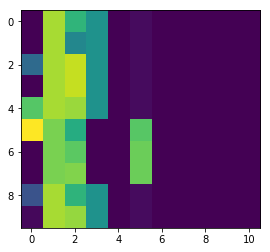

In [11]:
# Some examples
g = plt.imshow(X_train[100][:,:,0])
y_train[1000]

In [12]:
model = Sequential()
model.add(Conv2D(filters = nb_filters, kernel_size = (5, 5),
                 padding = 'Same', activation ='relu', input_shape = input_shape))
model.add(Conv2D(filters = nb_filters, kernel_size = (kernel_size[0],kernel_size[1]),
                 padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(0.4))

#model.add(Conv2D(filters = 64, kernel_size = (kernel_size[0],kernel_size[1]),
#                 padding = 'Same', activation ='relu'))
#model.add(Conv2D(filters = 64, kernel_size = (kernel_size[0],kernel_size[1]),
#                 padding = 'Same', activation ='relu'))
#model.add(MaxPooling2D(pool_size = pool_size))
#model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0001)

# Compile the model
model.compile(optimizer = optimizer,
              loss      = "categorical_crossentropy",
              metrics   = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 11, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               410112    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

### Training and Validation

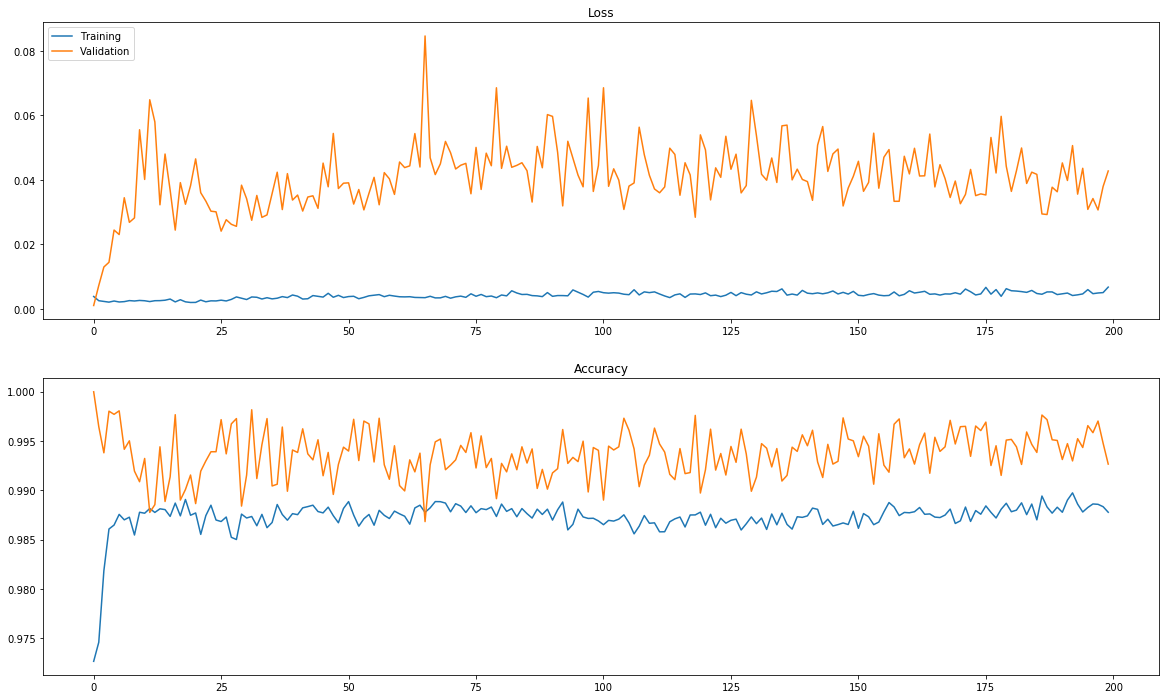

In [13]:
history = model.fit(X_train, y_train,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 0,  
                    validation_split = 0.2,  
                    class_weight = {0: cw0, 1: cw1})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(212)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Evaluation
def evaluation(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_ = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

    np.set_printoptions(precision=2)
    class_names = ["normal", "botnet"]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names,
                          title = 'Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names, normalize = True,
                          title = 'Normalized confusion matrix')
    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_true)/y_true.shape[0]))
    print("Accuracy    : %f" % accuracy_score(y_true, y_pred))
    print("Precision   : %f" % precision_score(y_true, y_pred))
    print("Recall      : %f" % recall_score(y_true, y_pred))
    print("F1-Score    : %f" % f1_score(y_true, y_pred))
    print("AUC         : %f" % auc_)
    plt.show()


In [15]:
score = model.evaluate(X_test, y_test, verbose = 2)  
print('Validation score:', score[0])  
print('Validation accuracy:', score[1])  

Validation score: 0.0255422226062
Validation accuracy: 0.993815229996


Confusion matrix, without normalization
[[15158    26]
 [   70   268]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.21  0.79]]
------------------------------------
Baseline    : 0.978224
Accuracy    : 0.993815
Precision   : 0.911565
Recall      : 0.792899
F1-Score    : 0.848101
AUC         : 0.895594


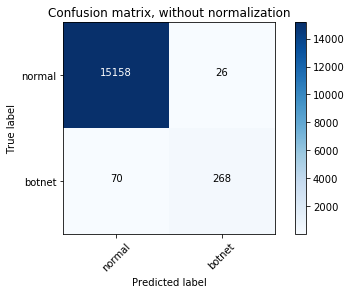

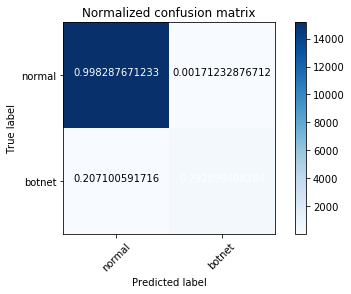

In [16]:
y_true = y_test[:,1]
y_pred = model.predict_classes(X_test, verbose = 2)
evaluation(y_true, y_pred)


In [17]:
X, X, input_shape = toimage(X, X, img_rows, img_cols)

model.fit(X, Y, batch_size = batch_size, epochs = nb_epoch, verbose = 2,
          validation_data = (X_test, y_test), class_weight = {0: cw0, 1: cw1})


Shape of data of input of rnn : (155219, 10, 11, 1)
Train on 155219 samples, validate on 15522 samples
Epoch 1/200
80s - loss: 0.0089 - acc: 0.9842 - val_loss: 0.0439 - val_acc: 0.9796
Epoch 2/200
80s - loss: 0.0111 - acc: 0.9866 - val_loss: 0.0787 - val_acc: 0.9790
Epoch 3/200
80s - loss: 0.0091 - acc: 0.9849 - val_loss: 0.0462 - val_acc: 0.9794
Epoch 4/200
80s - loss: 0.0080 - acc: 0.9853 - val_loss: 0.0534 - val_acc: 0.9794
Epoch 5/200
80s - loss: 0.0083 - acc: 0.9857 - val_loss: 0.0359 - val_acc: 0.9921
Epoch 6/200
79s - loss: 0.0085 - acc: 0.9862 - val_loss: 0.0473 - val_acc: 0.9795
Epoch 7/200
80s - loss: 0.0095 - acc: 0.9861 - val_loss: 0.0414 - val_acc: 0.9920
Epoch 8/200
79s - loss: 0.0101 - acc: 0.9866 - val_loss: 0.0523 - val_acc: 0.9793
Epoch 9/200
80s - loss: 0.0087 - acc: 0.9869 - val_loss: 0.0403 - val_acc: 0.9920
Epoch 10/200
80s - loss: 0.0081 - acc: 0.9867 - val_loss: 0.0320 - val_acc: 0.9921
Epoch 11/200
79s - loss: 0.0105 - acc: 0.9868 - val_loss: 0.0302 - val_acc: 

## Testing_11

In [18]:
df_11 = pd.read_csv("20110811_preprocessing.txt")
df_11_new = preprocessing(df_11)
df_11_mod = mod_pairwise_count(df_11_new, threshold=10)
X, Y, cw0, cw1 = reshape_Xy(df_11_mod, 961840, 10)
X, X, input_shape = toimage(X, X, img_rows, img_cols)

Dataset size of result : 1808122
              SrcAddr      DstAddr  number
77077   147.32.84.138  147.32.80.9  371144
135633   147.32.84.59  147.32.80.9   74762
160038   147.32.85.25  147.32.80.9   34136
161223   147.32.85.34  147.32.80.9   21637
176550   147.32.86.20  147.32.80.9   10230
number of size of Ip_pairwise > 10 : 7754
Size of modifying result  961841
Feature number of cnn_input : 12
Shape of data of input of rnn : (96184, 10, 11, 1)


Confusion matrix, without normalization
[[94132   215]
 [ 1795    42]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.98  0.02]]
------------------------------------
Baseline    : 0.980901
Accuracy    : 0.979103
Precision   : 0.163424
Recall      : 0.022863
F1-Score    : 0.040115
AUC         : 0.510292


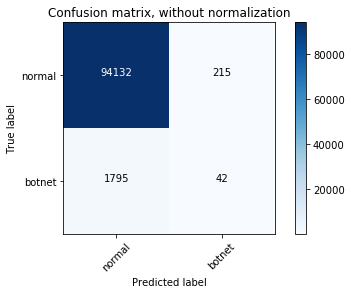

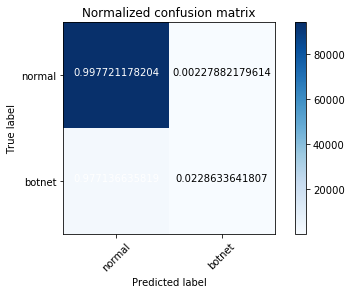

In [19]:
y_true = Y[:,1]
y_pred = model.predict_classes(X, verbose = 2)
evaluation(y_true, y_pred)


Baseline : 0.980901189387
Accuracy : 0.9791025534392415


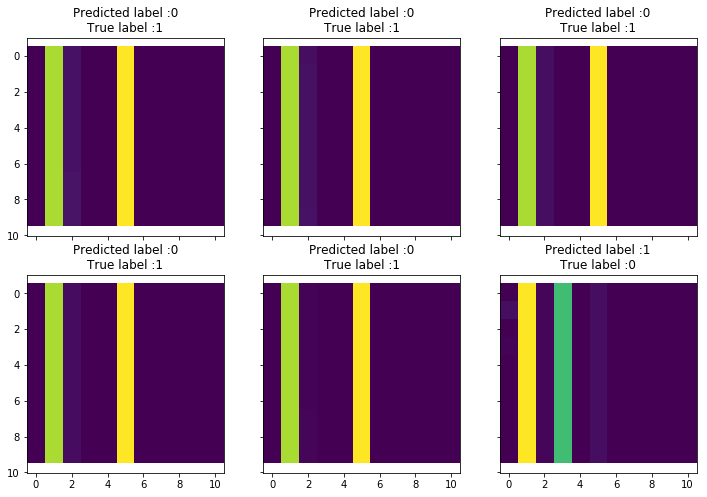

In [20]:
# Predict the values from the validation dataset
Y_pred = model.predict(X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y, axis = 1)

# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_errors = X[errors]
print ("Baseline :", sum(Y[:, 0])/Y.shape[0])
print ("Accuracy :", 1 - Y_pred_classes_errors.shape[0]/Y_pred_classes.shape[0])

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((img_errors.shape[1],img_errors.shape[2])))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_errors, Y_pred_classes_errors, Y_true_errors)


## Testing_19

In [21]:
df_19 = pd.read_csv("20110819_preprocessing.txt")
df_19_new = preprocessing(df_19)
df_19_mod = mod_pairwise_count(df_19_new, threshold=10)
X, Y, cw0, cw1 = reshape_Xy(df_19_mod, 189940, 10)
X, X, input_shape = toimage(X, X, img_rows, img_cols)


Dataset size of result : 325471
             SrcAddr      DstAddr  number
12849  147.32.84.138  147.32.80.9   54742
38483   147.32.84.59  147.32.80.9   18131
54784   147.32.85.25  147.32.80.9   11750
55145   147.32.85.34  147.32.80.9    6178
58580   147.32.86.20  147.32.80.9    2997
number of size of Ip_pairwise > 10 : 1601
Size of modifying result  189948
Feature number of cnn_input : 12
Shape of data of input of rnn : (18994, 10, 11, 1)


Confusion matrix, without normalization
[[18673   298]
 [    3    20]]
Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.13  0.87]]
------------------------------------
Baseline    : 0.998789
Accuracy    : 0.984153
Precision   : 0.062893
Recall      : 0.869565
F1-Score    : 0.117302
AUC         : 0.926929


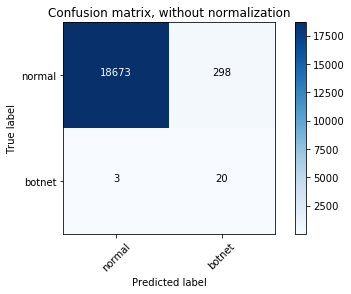

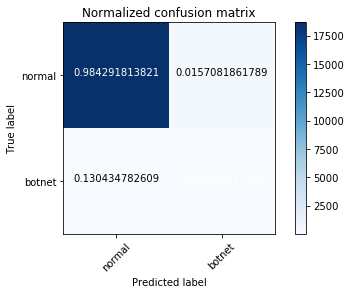

In [22]:
y_true = Y[:,1]
y_pred = model.predict_classes(X, verbose = 2)
evaluation(y_true, y_pred)


Baseline : 0.998789091292
Accuracy : 0.9841528903864378


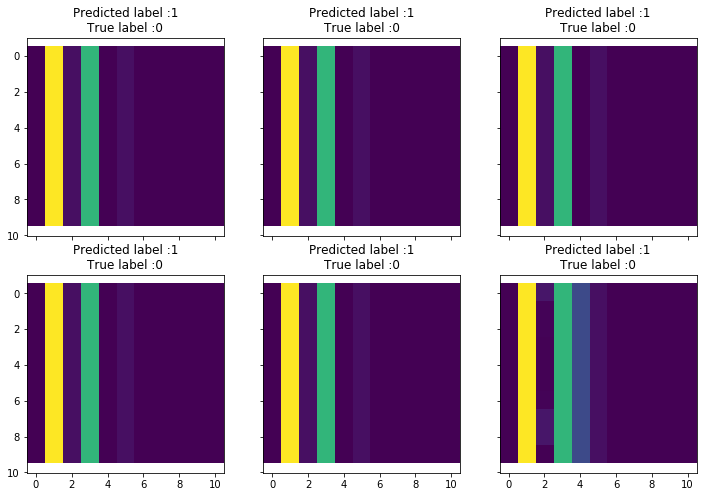

In [23]:
# Predict the values from the validation dataset
Y_pred = model.predict(X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y, axis = 1)

# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_errors = X[errors]
print ("Baseline :", sum(Y[:, 0])/Y.shape[0])
print ("Accuracy :", 1 - Y_pred_classes_errors.shape[0]/Y_pred_classes.shape[0])

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((img_errors.shape[1],img_errors.shape[2])))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_errors, Y_pred_classes_errors, Y_true_errors)


> 我們利用整理好的ctu13資料，將每一對pair_IP取出，然後把資料量小於10的pair_IP刪除。再來我們已10筆為一單位，將其轉換成image的形式，在training的時候其實有不錯的效果，但是在test和其他data中的效果很差。